<a href="https://colab.research.google.com/github/Aayushmittalwebpage/Pro-Text/blob/master/CRF_BILSTM_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1LeWe51FyXVVu1iSf1BIZZo24tif3x12Z'})
downloaded.GetContentFile('df1_new.csv') # df1_new is the processed data

In [0]:
df1 = pd.read_csv('df1_new.csv')
df1.drop(["Unnamed: 0"], axis = 1, inplace = True) 
data = df1
data.head()

,pos,sentence_idx,word,tag
0,ADV,1,f,_
1,ADV,1,out,P
2,ADV,1,out,P
3,NC,1,sortie,P
4,DELIM,1,Â§,_


In [0]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite


import matplotlib.pyplot as plt
import tensorflow as tf
import keras

     |████████████████████████████████| 747kB 4.0MB/s 


Using TensorFlow backend.


In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-05-19 11:08:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-19 11:08:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-19 11:08:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
!unzip glove*.zip

!ls

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
adc.json     glove.6B.100d.txt	glove.6B.300d.txt  glove.6B.zip
df1_new.csv  glove.6B.200d.txt	glove.6B.50d.txt   sample_data


In [0]:
# importing glove
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [0]:
BATCH_SIZE = 32
EPOCHS = 5
MAX_LEN = 75
EMBEDDING = 300

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
class SentenceGetter(object):

    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('f', 'ADV', '_'), ('out', 'ADV', 'P'), ('out', 'ADV', 'P'), ('sortie', 'NC', 'P'), ('Â§', 'DELIM', '_')]


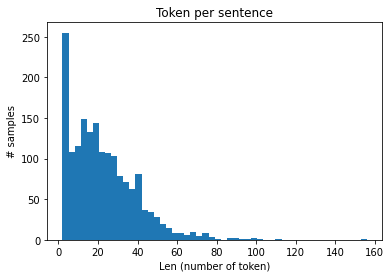

In [0]:
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [0]:
words = list(set(data["word"].values))
n_words = len(words)

tags = list(set(data["tag"].values))
n_tags = len(tags)

word2idx = {w: i + 2 for i, w in enumerate(words)}

In [0]:
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # 'PAD' is the word used for smaller sentences, to make the size of all sentences common

In [0]:
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [0]:
idx2tag

{0: 'PAD', 1: '_', 2: 'P'}

In [0]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

In [0]:
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

In [0]:
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((1539, 75), (171, 75), (1539, 75, 3), (171, 75, 3))

In [0]:
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  f out out sortie Â§
Raw Label:  _ P P P _
After processing, sample: [1590 2208 2208 3155  608    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
After processing, labels: [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0

In [0]:
n_wor = n_words+2 
num_words = min(n_wor, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
    if i >= n_wor:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, input_length=MAX_LEN, weights=[embedding_matrix])(input)  
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 300)           1429800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           140400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 3)             168       
Total params: 1,575,418
Trainable params: 145,618
Non-trainable params: 1,429,800
_________________________________________________________________


In [0]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Train on 1385 samples, validate on 154 samples
Epoch 1/5
 - 7s - loss: 0.3767 - crf_viterbi_accuracy: 0.8348 - val_loss: 0.1575 - val_crf_viterbi_accuracy: 0.9363
Epoch 2/5
 - 5s - loss: 0.1442 - crf_viterbi_accuracy: 0.9427 - val_loss: 0.1379 - val_crf_viterbi_accuracy: 0.9479
Epoch 3/5
 - 5s - loss: 0.1301 - crf_viterbi_accuracy: 0.9486 - val_loss: 0.1315 - val_crf_viterbi_accuracy: 0.9500
Epoch 4/5
 - 5s - loss: 0.1231 - crf_viterbi_accuracy: 0.9496 - val_loss: 0.1245 - val_crf_viterbi_accuracy: 0.9474
Epoch 5/5
 - 5s - loss: 0.1183 - crf_viterbi_accuracy: 0.9511 - val_loss: 0.1199 - val_crf_viterbi_accuracy: 0.9512


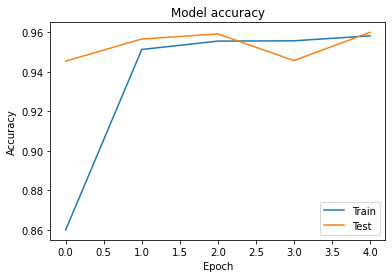

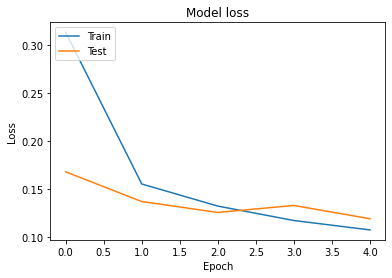

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Evaluation
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [0]:
from sklearn_crfsuite.metrics import flat_classification_report    ### using glove
# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

              precision    recall  f1-score   support

           P       0.49      0.22      0.30       674
         PAD       1.00      1.00      1.00      8755
           _       0.86      0.95      0.90      3396

    accuracy                           0.94     12825
   macro avg       0.78      0.72      0.73     12825
weighted avg       0.93      0.94      0.94     12825



In [0]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 161 of 171 (Test Set)
Word           ||True ||Pred
s              : P     P
,              : P     _
qui            : _     P
manifeste      : _     _
l'             : P     _
importance     : _     _
de             : _     _
la             : P     _
reformulation  : _     _
au             : P     _
sein           : _     _
des            : _     _
sciences       : _     _
du             : _     _
langage        : _     _
.              : _     _
Â§             : _     _


In [0]:
!ls

adc.json     glove.6B.100d.txt	glove.6B.300d.txt  glove.6B.zip
df1_new.csv  glove.6B.200d.txt	glove.6B.50d.txt   sample_data
